In [1]:
import os
import ctypes
from symfit import variables, Parameter, ODEModel, D, Fit, parameters, Variable
import numpy as np
from uncertainties import ufloat as uf
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from pathlib import Path as pt
from ipywidgets import widgets
from timescan import timescanplot
from time import time as start_time
os.getcwd()

'D:\\FELion_GUI3\\static\\assets\\python_files\\ODE'

In [2]:
%matplotlib inline

In [3]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [24]:
def definingParameter(value):
    exec(value)
    return locals()

def getValfromAddress(address):
    return ctypes.cast(address, ctypes.py_object).value

def getValfromVariable(variable):
    address = id(variable)
    return getValfromAddress(address)

In [25]:
import string
alphabets = string.ascii_uppercase

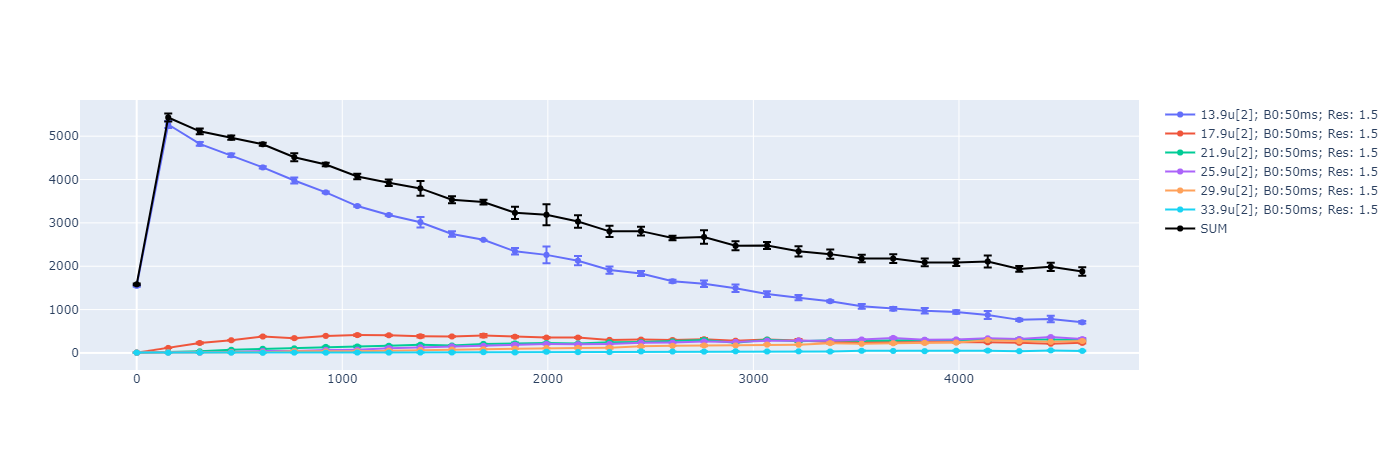

In [5]:

file = pt('./30_08_19-1.scan')

location = os.getcwd()
time, mean, error, mass, t_res, t_b0  = timescanplot(file).get_data()
m = timescanplot(file).get_fullmass()

data = list(m.values())
iplot(data)

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [6]:
style = {'description_width': 'initial', 'width':"100"}
layout=widgets.Layout(width='50%')

totalReactionsNumber = len(mass)

numberOfReaction = widgets.BoundedIntText(description="numberOfReaction", style = style, value=totalReactionsNumber, layout=layout)
nameOfReactants = widgets.Text(description="nameOfReactants", style = style, value=", ".join([f"{i}u" for i in mass]), layout=layout)
labelnameOfReactants = widgets.Text(description="labelnameOfReactants", style = style, value="CD, CDHe, CDHe2, CDHe3, CDHe4, CDHe5", layout=layout)
nameOfParametersForward = widgets.Text(description="nameOfParametersForward", style = style,value=", ".join([f"k3{i}" for i in range(1, totalReactionsNumber)]), layout=layout)
nameOfParametersReverse = widgets.Text(description="nameOfParametersReverse", style = style,value=", ".join([f"CID{i}" for i in range(1, totalReactionsNumber)]), layout=layout)
parameterMinMaxStepForward = widgets.Text(description="parameterMinMaxStep", style = style, value="-40, -20, 0.001")
parameterMinMaxStepReverse = widgets.Text(description="parameterMinMaxStep", style = style, value="-30, -10, 0.001")

kineticsWidget = [numberOfReaction, nameOfReactants, labelnameOfReactants, nameOfParametersForward, parameterMinMaxStepForward, nameOfParametersReverse, parameterMinMaxStepReverse]

display(*kineticsWidget)

BoundedIntText(value=6, description='numberOfReaction', layout=Layout(width='50%'), style=DescriptionStyle(des…

Text(value='13.9u, 17.9u, 21.9u, 25.9u, 29.9u, 33.9u', description='nameOfReactants', layout=Layout(width='50%…

Text(value='CD, CDHe, CDHe2, CDHe3, CDHe4, CDHe5', description='labelnameOfReactants', layout=Layout(width='50…

Text(value='k31, k32, k33, k34, k35', description='nameOfParametersForward', layout=Layout(width='50%'), style…

Text(value='-40, -20, 0.001', description='parameterMinMaxStep', style=DescriptionStyle(description_width='ini…

Text(value='CID1, CID2, CID3, CID4, CID5', description='nameOfParametersReverse', layout=Layout(width='50%'), …

Text(value='-30, -10, 0.001', description='parameterMinMaxStep', style=DescriptionStyle(description_width='ini…

In [31]:
timeStartIndex = 2
endtimeIndex = -1
print(f'{timeStartIndex=}, {endtimeIndex=}')

expTime = time[timeStartIndex:endtimeIndex] / 1000
fullData = {}

for key in nameOfReactants.value.split(", "):
    fullData[key] = m[key]['y'][timeStartIndex:endtimeIndex]
    
fullDataValues = np.array(list(fullData.values()))

timeStartIndex=2, endtimeIndex=-1


In [8]:
t = Variable("t")

reactantVariable = variables(labelnameOfReactants.value)
reactantVariableAddress = [id(i) for i in reactantVariable]

print(f"{reactantVariable=}\n{reactantVariableAddress=}")

label = labelnameOfReactants.value.split(", ")
if len(label) == 0:
    label = [alphabets[i] for i in range(len(totalReactionsNumber))]
    
initialCondition = fullDataValues.T[0]
print(initialCondition)

initialConditionWidgets = []


for i, val in enumerate(initialCondition):
    _widget = widgets.BoundedFloatText(value=val, description=f"{label[i]}+", max=1e20, min=0, step=20)
    initialConditionWidgets.append(_widget)
    
display(*initialConditionWidgets)

reactantVariable=(CD, CDHe, CDHe2, CDHe3, CDHe4, CDHe5)
reactantVariableAddress=[1686026035984, 1686026035744, 1686026036864, 1686026037024, 1686026037184, 1686026037344]
[4822.   229.    36.     6.5   11.     7.5]


BoundedFloatText(value=4822.0, description='CD+', max=1e+20, step=20.0)

BoundedFloatText(value=229.0, description='CDHe+', max=1e+20, step=20.0)

BoundedFloatText(value=36.0, description='CDHe2+', max=1e+20, step=20.0)

BoundedFloatText(value=6.5, description='CDHe3+', max=1e+20, step=20.0)

BoundedFloatText(value=11.0, description='CDHe4+', max=1e+20, step=20.0)

BoundedFloatText(value=7.5, description='CDHe5+', max=1e+20, step=20.0)

In [27]:
# Initial condition
initial_cond = {t:0}

for i, variable in enumerate(reactantVariable):
    initial_cond[getValfromVariable(variable)] = initialConditionWidgets[i].value
    
print(initial_cond)
list(initial_cond.keys())[1] == reactantVariable[0]

{t: 0, CD: 4822.0, CDHe: 229.0, CDHe2: 36.0, CDHe3: 6.5, CDHe4: 11.0, CDHe5: 7.5}


True

True

In [11]:
# He/Ne number density

def numberDensity(temp, pbefore, pafter):
    
    constant = 4.18e17 # 1/boltzman_constant*sqrt(T)
    C = uf(205.54, 2.5) # Calibration factor 
    T = uf(temp, 0.1) # Temperature
    p = pafter - pbefore
    N = (constant*C*p)/(T**0.5)
    print(N) 
    return N.nominal_value

tempWidget = widgets.BoundedFloatText(value=4.5, min=0, max=400, step=0.5)
pbeforeWidget = widgets.FloatLogSlider(base=10, value=1e-9, min=-10, max=-4)
paftereWidget = widgets.FloatLogSlider(base=10, value=1e-7, min=-10, max=-4)

numberDensityWidgetOutput = widgets.interact(numberDensity, temp=tempWidget, pbefore=pbeforeWidget, pafter=paftereWidget)

interactive(children=(BoundedFloatText(value=4.5, description='temp', max=400.0, step=0.5), FloatLogSlider(val…

In [12]:
He = numberDensityWidgetOutput.widget.result
print(f"{He=}")

rateConstantParametersForward = parameters(nameOfParametersForward.value)
rateConstantParametersReverse = parameters(nameOfParametersReverse.value)

rateEquation = {"forward":[He**2 * getValfromVariable(i) for i in rateConstantParametersForward],
                "reverse":[He * getValfromVariable(i) for i in rateConstantParametersReverse]}

rateEquation

He=4009604822686.6294


{'forward': [1.60769308341119e+25*k31,
  1.60769308341119e+25*k32,
  1.60769308341119e+25*k33,
  1.60769308341119e+25*k34,
  1.60769308341119e+25*k35],
 'reverse': [4009604822686.63*CID1,
  4009604822686.63*CID2,
  4009604822686.63*CID3,
  4009604822686.63*CID4,
  4009604822686.63*CID5]}

In [13]:
formationRate = {}

for i, forward, reverse in zip(range(len(rateEquation["forward"])), rateEquation["forward"], rateEquation["reverse"]):
    formationRate[f"{label[i]}"] = -getValfromVariable(forward)*getValfromVariable(reactantVariable[i]) + getValfromVariable(reverse)*getValfromVariable(reactantVariable[i+1])

formationRateList = list(formationRate.values())
formationRate[f"{label[-1]}"] =  -formationRateList[-1]
formationRateList = list(formationRate.values())
formationRate, reactantVariable

({'CD': 4009604822686.63*CID1*CDHe - 1.60769308341119e+25*k31*CD,
  'CDHe': 4009604822686.63*CID2*CDHe2 - 1.60769308341119e+25*k32*CDHe,
  'CDHe2': 4009604822686.63*CID3*CDHe3 - 1.60769308341119e+25*k33*CDHe2,
  'CDHe3': 4009604822686.63*CID4*CDHe4 - 1.60769308341119e+25*k34*CDHe3,
  'CDHe4': 4009604822686.63*CID5*CDHe5 - 1.60769308341119e+25*k35*CDHe4,
  'CDHe5': -4009604822686.63*CID5*CDHe5 + 1.60769308341119e+25*k35*CDHe4},
 (CD, CDHe, CDHe2, CDHe3, CDHe4, CDHe5))

In [14]:
rate_model = {D(getValfromVariable(reactantVariable[0]), t): getValfromVariable(formationRateList[0]) }
for i in range(1, totalReactionsNumber-1):
    rate_model[D(getValfromVariable(reactantVariable[i]), t)] =  getValfromVariable(formationRateList[i]) -getValfromVariable(formationRateList[i-1])
    
rate_model[D(getValfromVariable(reactantVariable[-1]), t)] = getValfromVariable(formationRateList[-1])

for i, j in rate_model.items():
    print(f"\n{i}:{j}")


Derivative(CD, t):4009604822686.63*CID1*CDHe - 1.60769308341119e+25*k31*CD

Derivative(CDHe, t):-4009604822686.63*CID1*CDHe + 4009604822686.63*CID2*CDHe2 + 1.60769308341119e+25*k31*CD - 1.60769308341119e+25*k32*CDHe

Derivative(CDHe2, t):-4009604822686.63*CID2*CDHe2 + 4009604822686.63*CID3*CDHe3 + 1.60769308341119e+25*k32*CDHe - 1.60769308341119e+25*k33*CDHe2

Derivative(CDHe3, t):-4009604822686.63*CID3*CDHe3 + 4009604822686.63*CID4*CDHe4 + 1.60769308341119e+25*k33*CDHe2 - 1.60769308341119e+25*k34*CDHe3

Derivative(CDHe4, t):-4009604822686.63*CID4*CDHe4 + 4009604822686.63*CID5*CDHe5 + 1.60769308341119e+25*k34*CDHe3 - 1.60769308341119e+25*k35*CDHe4

Derivative(CDHe5, t):-4009604822686.63*CID5*CDHe5 + 1.60769308341119e+25*k35*CDHe4


In [15]:
ode_model = ODEModel(rate_model, initial=initial_cond)

print(ode_model)

print(ode_model.dependent_vars[0] == list(ode_model.initial.keys())[1])

Derivative(CD, t; CID1, CID2, CID3, CID4, CID5, k31, k32, k33, k34, k35) = 4009604822686.63*CID1*CDHe - 1.60769308341119e+25*k31*CD
Derivative(CDHe, t; CID1, CID2, CID3, CID4, CID5, k31, k32, k33, k34, k35) = -4009604822686.63*CID1*CDHe + 4009604822686.63*CID2*CDHe2 + 1.60769308341119e+25*k31*CD - 1.60769308341119e+25*k32*CDHe
Derivative(CDHe2, t; CID1, CID2, CID3, CID4, CID5, k31, k32, k33, k34, k35) = -4009604822686.63*CID2*CDHe2 + 4009604822686.63*CID3*CDHe3 + 1.60769308341119e+25*k32*CDHe - 1.60769308341119e+25*k33*CDHe2
Derivative(CDHe3, t; CID1, CID2, CID3, CID4, CID5, k31, k32, k33, k34, k35) = -4009604822686.63*CID3*CDHe3 + 4009604822686.63*CID4*CDHe4 + 1.60769308341119e+25*k33*CDHe2 - 1.60769308341119e+25*k34*CDHe3
Derivative(CDHe4, t; CID1, CID2, CID3, CID4, CID5, k31, k32, k33, k34, k35) = -4009604822686.63*CID4*CDHe4 + 4009604822686.63*CID5*CDHe5 + 1.60769308341119e+25*k34*CDHe3 - 1.60769308341119e+25*k35*CDHe4
Derivative(CDHe5, t; CID1, CID2, CID3, CID4, CID5, k31, k32, k3

In [33]:
tdata = widgets.BoundedFloatText(
    value=5,
    min=1,
    max=20,
    step=0.25,
    description='Simulation:',
)
logPlot = widgets.Checkbox(description="Log", value=True)

In [17]:
def float_slider(_value, _description, _min = -40, _max = -20, steps = 1e-3):
    return widgets.FloatLogSlider(
                value=_value,
                base=10,
                min=_min,
                max=_max,
                step=steps,
                description=_description
            )

rateConstantSliderWidget = {"t":tdata}

_minF, _maxF, _stepF = parameterMinMaxStepForward.value.split(", ")
_minR, _maxR, _stepR = parameterMinMaxStepReverse.value.split(", ")

for forwarLabel, reverseLabel in zip(nameOfParametersForward.value.split(", "), nameOfParametersReverse.value.split(", ")):
    _sliderWidgetForward = float_slider(1e-30, forwarLabel, _minF, _maxF, _stepF)
    _sliderWidgetReverse = float_slider(1e-15, reverseLabel, _minR, _maxR, _stepR)
    
    rateConstantSliderWidget[forwarLabel] = _sliderWidgetForward
    rateConstantSliderWidget[reverseLabel] = _sliderWidgetReverse

rateConstantSliderWidget

{'t': BoundedFloatText(value=5.0, description='Simulation:', max=20.0, min=1.0, step=0.25),
 'k31': FloatLogSlider(value=1e-30, description='k31', max=-20.0, min=-40.0, step=0.001),
 'CID1': FloatLogSlider(value=1e-15, description='CID1', max=-10.0, min=-30.0, step=0.001),
 'k32': FloatLogSlider(value=1e-30, description='k32', max=-20.0, min=-40.0, step=0.001),
 'CID2': FloatLogSlider(value=1e-15, description='CID2', max=-10.0, min=-30.0, step=0.001),
 'k33': FloatLogSlider(value=1e-30, description='k33', max=-20.0, min=-40.0, step=0.001),
 'CID3': FloatLogSlider(value=1e-15, description='CID3', max=-10.0, min=-30.0, step=0.001),
 'k34': FloatLogSlider(value=1e-30, description='k34', max=-20.0, min=-40.0, step=0.001),
 'CID4': FloatLogSlider(value=1e-15, description='CID4', max=-10.0, min=-30.0, step=0.001),
 'k35': FloatLogSlider(value=1e-30, description='k35', max=-20.0, min=-40.0, step=0.001),
 'CID5': FloatLogSlider(value=1e-15, description='CID5', max=-10.0, min=-30.0, step=0.001)

In [38]:
def func(log=True, **kwargs):
    
    print(kwargs)
    
    # Simulation time
    simulationTime = kwargs["t"] = np.linspace(0, kwargs["t"], 1000)
    
    simulationData = ode_model(**kwargs)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    color = 0
    for sim, exp, lg in zip(simulationData, fullDataValues, label):
        ax.plot(simulationTime, sim, f"C{color}", label=f"{lg}$^+$")
        ax.plot(expTime, exp, f".C{color}")
        color += 1
        
    plt.ylabel('Counts')
    plt.xlabel('Time (s)')
    
    plt.grid()
    if log: plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.2, 1))
    plt.show()
    plt.close('all')

out = widgets.interactive_output(func,  {"log":logPlot, **rateConstantSliderWidget})
display(*list(rateConstantSliderWidget.values()), out)

BoundedFloatText(value=5.0, description='Simulation:', max=20.0, min=1.0, step=0.25)

FloatLogSlider(value=2.884031503126612e-26, description='k31', max=-20.0, min=-40.0, step=0.001)

FloatLogSlider(value=1e-15, description='CID1', max=-10.0, min=-30.0, step=0.001)

FloatLogSlider(value=4.405548635065517e-25, description='k32', max=-20.0, min=-40.0, step=0.001)

FloatLogSlider(value=1e-15, description='CID2', max=-10.0, min=-30.0, step=0.001)

FloatLogSlider(value=1e-30, description='k33', max=-20.0, min=-40.0, step=0.001)

FloatLogSlider(value=1e-15, description='CID3', max=-10.0, min=-30.0, step=0.001)

FloatLogSlider(value=1e-30, description='k34', max=-20.0, min=-40.0, step=0.001)

FloatLogSlider(value=1e-15, description='CID4', max=-10.0, min=-30.0, step=0.001)

FloatLogSlider(value=1e-30, description='k35', max=-20.0, min=-40.0, step=0.001)

FloatLogSlider(value=1e-15, description='CID5', max=-10.0, min=-30.0, step=0.001)

Checkbox(value=True, description='Log')

Output()

In [36]:
time.size, fullDataValues[0].size

(31, 28)